<a href="https://www.kaggle.com/code/micheldc55/tutorial-redes-neuronales-para-regresi-n?scriptVersionId=113798158" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## RNN: REGRESION - Predicción de precios vivienda


El set de datos SaratogaHouses del paquete mosaicData de R contiene información sobre el precio de 1728 viviendas situadas en Saratoga County, New York, USA en el año 2006. Además del precio, incluye 15 variables adicionales:

- price: precio de la vivienda.
- lotSize: metros cuadrados de la vivienda.
- age: antigüedad de la vivienda.
- landValue: valor del terreno.
- livingArea: metros cuadrados habitables.
- pctCollege: porcentaje del vecindario con título universitario.
- bedrooms: número de dormitorios.
- firplaces: número de chimeneas.
- bathrooms: número de cuartos de baño (el valor 0.5 hace referencia a cuartos de baño sin ducha).
- rooms: número de habitaciones.
- heating: tipo de calefacción.
- fuel: tipo de alimentación de la calefacción (gas, electricidad o diesel).
- sewer: tipo de desagüe.
- waterfront: si la vivienda tiene vistas al lago.
- newConstruction: si la vivienda es de nueva construcción.
- centralAir: si la vivienda tiene aire acondicionado.

El objetivo es obtener un modelo capaz de predecir el precio del alquiler.

## Librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lectura de datos
# ==============================================================================

datos = pd.read_csv('../input/boston-housing-in-spanish/boston_housing_esp.csv')

In [3]:
datos.head()

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


## Análisis exploratorio


Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores. Algunos ejemplos frecuentes son:

Que una columna se haya almacenado con el tipo incorrecto: una variable numérica está siendo reconocida como texto o viceversa.

Que una variable contenga valores que no tienen sentido: por ejemplo, para indicar que no se dispone del precio de una vivienda se introduce el valor 0 o un espacio en blanco.

Que en una variable de tipo numérico se haya introducido una palabra en lugar de un número.

Además, este análisis inicial puede dar pistas sobre qué variables son adecuadas como predictores en un modelo.

In [4]:
# Tipo de cada columna
# ==============================================================================
# Recordar que en pandas, el tipo "object" hace referencia a strings
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

Todas las columnas tienen el tipo de dato correcto.



In [5]:
# Número de datos ausentes por variable
# ==============================================================================
datos.isna().sum().sort_values()

precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
chimenea              0
banyos                0
habitaciones          0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

Todas las columnas están completas, no hay valores ausentes.

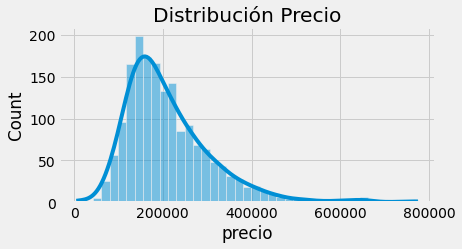

In [6]:
# Distribución variable respuesta
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=datos, x='precio', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('precio');

Los modelos de redes neuronales son de tipo no paramétrico, no asumen ningún tipo de distribución de la variable respuesta, por lo tanto, no es necesario que esta siga ninguna distribución concreta (normal, gamma...). Aun así, siempre es recomendable hacer un estudio mínimo, ya que, a fin de cuentas, es lo que interesa predecir. En este caso, la variable precio tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, tienen un precio muy superior a la media.

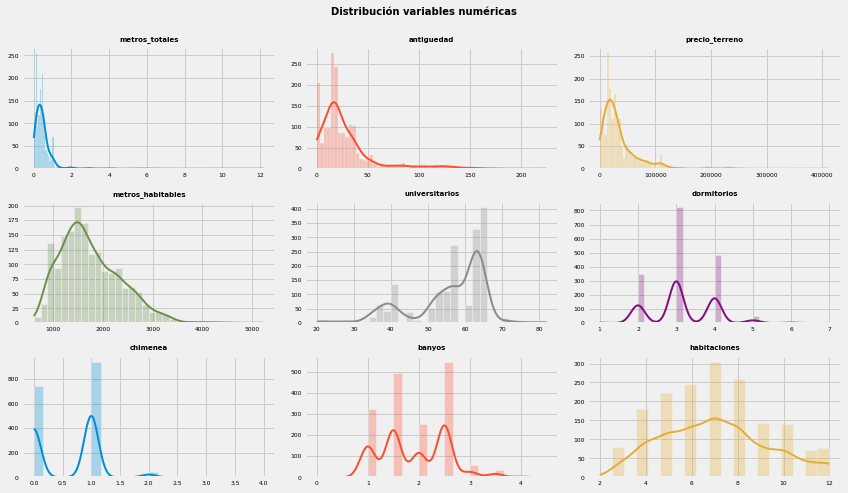

In [7]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La variable chimenea, aunque es de tipo numérico, apenas toma unos pocos valores y la gran mayoría de observaciones pertenecen a solo dos de ellos. En casos como este, suele ser conveniente tratar la variable como cualitativa.

In [8]:
# Valores observados de chimenea
# ==============================================================================
datos.chimenea = datos.chimenea.astype("str")
datos.chimenea.value_counts()

1    942
0    740
2     42
4      2
3      2
Name: chimenea, dtype: int64

In [9]:
# Variables cualitativas (tipo object)
# ==============================================================================
datos.select_dtypes(include=['object']).describe()

,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728,1728
unique,5,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,942,1121,1197,1213,1713,1647,1093


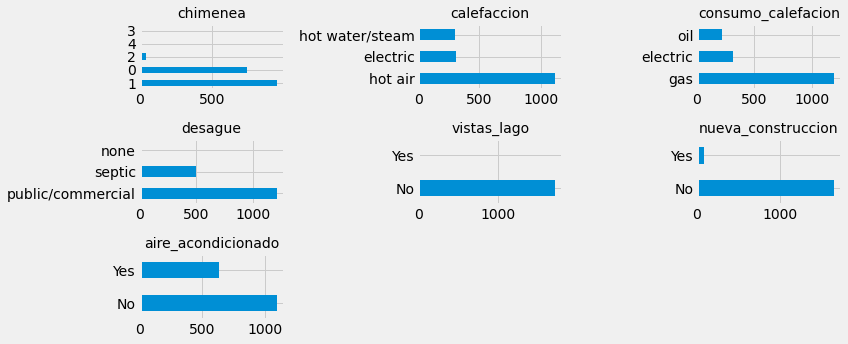

In [10]:
# Gráfico para cada variable cualitativa
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()

Si alguno de los niveles de una variable cualitativa tiene muy pocas observaciones en comparación a los otros niveles, puede ocurrir que, durante la validación cruzada o bootstrapping, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo que puede dar lugar a errores. Para este caso, hay que tener precaución con la variable chimenea. Se unifican los niveles de 2, 3 y 4 en un nuevo nivel llamado "2_mas".

In [11]:
dic_replace = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

datos['chimenea'] = datos['chimenea'] \
                     .map(dic_replace) \
                     .fillna(datos['chimenea'])
datos.chimenea.value_counts().sort_index()

0        740
1        942
2_mas     46
Name: chimenea, dtype: int64

## División train y test


Con el objetivo de poder estimar el error que comete el modelo al predecir nuevas observaciones, se dividen los datos en dos grupos, uno de entrenamiento y otro de test (80%, 20%).

In [12]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('precio', axis = 'columns'),
                                        datos['precio'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [13]:
print("Partición de entrenamento")
print("-----------------------")
display(y_train.describe())
display(X_train.describe())
display(X_train.describe(include = 'object'))
print(" ")

print("Partición de test")
print("-----------------------")
display(y_test.describe())
display(X_test.describe())
display(X_test.describe(include = 'object'))

Partición de entrenamento
-----------------------


count      1382.000000
mean     211436.516643
std       96846.639129
min       10300.000000
25%      145625.000000
50%      190000.000000
75%      255000.000000
max      775000.000000
Name: precio, dtype: float64

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.501331,27.494211,34232.141823,1755.940666,55.439942,3.165702,1.902677,7.073082
std,0.671766,28.212721,35022.662319,621.262215,10.356656,0.825487,0.660053,2.315395
min,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,0.000000,2.000000
25%,0.170000,13.000000,15100.000000,1302.000000,52.000000,3.000000,1.500000,5.000000
50%,0.370000,19.000000,25000.000000,1650.000000,57.000000,3.000000,2.000000,7.000000
75%,0.540000,33.750000,39200.000000,2127.250000,63.000000,4.000000,2.500000,9.000000
max,8.970000,201.000000,412600.000000,4856.000000,82.000000,7.000000,4.500000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1382,1382,1382,1382,1382,1382,1382
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,741,915,972,970,1370,1321,863


 
Partición de test
-----------------------


count       346.000000
mean     214084.395954
std      104689.155889
min        5000.000000
25%      139000.000000
50%      180750.000000
75%      271750.000000
max      670000.000000
Name: precio, dtype: float64

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,0.495751,29.601156,35855.491329,1751.121387,56.078035,3.109827,1.890173,6.916185
std,0.798240,32.884116,35035.761216,615.486848,10.239861,0.783575,0.652368,2.319776
min,0.010000,0.000000,300.000000,792.000000,20.000000,1.000000,1.000000,2.000000
25%,0.160000,13.000000,15100.000000,1296.000000,52.000000,3.000000,1.500000,5.000000
50%,0.370000,19.000000,26700.000000,1608.000000,57.000000,3.000000,2.000000,7.000000
75%,0.557500,34.000000,45950.000000,2181.000000,64.000000,4.000000,2.500000,8.000000
max,12.200000,225.000000,233000.000000,5228.000000,82.000000,6.000000,4.000000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,346,346,346,346,346,346,346
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,201,206,225,243,343,326,230


## Preprocesado


Los modelos de redes neuronales requieren como mínimo de dos tipos de preprocesado: binarización (One hot ecoding) de las variables categóricas y estandarización de las variables continuas.


In [14]:
# Selección de las variables por típo
# ==============================================================================
# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [15]:
set_config(display='diagram')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['metros_totales', 'antiguedad',
                                  'precio_terreno', 'metros_habitables',
                                  'universitarios', 'dormitorios', 'banyos',
                                  'habitaciones']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['chimenea', 'calefaccion',
                                  'consumo_calefacion', 'desague',
                                  'vistas_lago', 'nueva_construccion',
                                  'aire_acondicionado'])])

In [16]:
# Se aprenden y aplican las transformaciones de preprocesado
# ==============================================================================
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [17]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metros_totales               1382 non-null   float64
 1   antiguedad                   1382 non-null   float64
 2   precio_terreno               1382 non-null   float64
 3   metros_habitables            1382 non-null   float64
 4   universitarios               1382 non-null   float64
 5   dormitorios                  1382 non-null   float64
 6   banyos                       1382 non-null   float64
 7   habitaciones                 1382 non-null   float64
 8   chimenea_0                   1382 non-null   float64
 9   chimenea_1                   1382 non-null   float64
 10  chimenea_2_mas               1382 non-null   float64
 11  calefaccion_electric         1382 non-null   float64
 12  calefaccion_hot air          1382 non-null   float64
 13  calefaccion_hot wa

In [18]:
datos_train_prep

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones,chimenea_0,chimenea_1,...,consumo_calefacion_oil,desague_none,desague_public/commercial,desague_septic,vistas_lago_No,vistas_lago_Yes,nueva_construccion_No,nueva_construccion_Yes,aire_acondicionado_No,aire_acondicionado_Yes
0,-0.061549,0.301597,-0.195148,1.320467,0.826826,1.011039,0.905289,2.128665,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.195573,-0.407560,-0.277982,0.194931,0.730235,1.011039,1.663079,1.264569,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.072475,-0.478476,-0.892092,-0.064313,-1.877728,1.011039,0.147500,-0.463623,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.121115,0.159766,-0.138022,0.254509,0.730235,-0.200805,-0.610289,-0.895671,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.523186,-0.974885,0.050496,0.484768,0.150688,-0.200805,0.905289,0.832521,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,-0.686993,-0.301186,-0.246562,-0.869417,0.633644,-1.412649,0.147500,-1.327719,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1378,-0.612535,-0.336644,-0.475068,-0.444322,0.730235,-0.200805,-0.610289,0.400473,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1379,-0.091332,-0.726680,-0.286551,-0.689074,0.826826,-0.200805,0.905289,0.400473,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1380,-0.657210,-0.443018,0.353267,0.876049,0.150688,-0.200805,1.663079,1.264569,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Si bien realizar el preprocesado de forma separada del entrenamiento es útil para explorar y confirmar que las transformaciones realizadas son las deseadas, en la práctica, es más adecuado asociarlo al propio proceso de entrenamiento. Esto puede hacerse fácilmente en los modelos de scikit-learn con los Pipeline.

## Modelado

Pipepeline de preprocesado + modelado

In [19]:
# Pipeline de preprocedado y modelado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [20]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
41,0.001,10,10.0,-3.377180e+09,8.514320e+08,-2.518859e+09,1.534161e+08
26,0.001,10,0.004642,-3.417108e+09,6.872883e+08,-2.483839e+09,1.181593e+08
31,0.001,10,215.443469,-3.428416e+09,7.612618e+08,-2.555949e+09,2.197194e+08
20,0.001,10,0.021544,-3.451399e+09,6.038079e+08,-2.660865e+09,8.247659e+07
15,0.001,10,0.001,-3.486670e+09,7.787699e+08,-2.558115e+09,2.381631e+08
38,0.001,"(10, 10)",0.001,-3.488048e+09,6.992953e+08,-2.285744e+09,3.257206e+08
25,0.01,10,0.001,-3.495356e+09,8.483200e+08,-2.546466e+09,2.886335e+08
34,0.01,"(10, 10)",10.0,-3.503644e+09,8.170092e+08,-2.465673e+09,3.121665e+08
48,0.01,"(10, 10)",46.415888,-3.530919e+09,4.542759e+08,-2.219683e+09,2.008229e+08
32,0.01,10,0.004642,-3.543909e+09,6.715854e+08,-2.458064e+09,2.039485e+08


## Error de test


Aunque mediante los métodos de validación (Kfold, LeaveOneOut) se consiguen buenas estimaciones del error que tiene un modelo al predecir nuevas observaciones, la mejor forma de evaluar un modelo final es prediciendo un conjunto test, es decir, un conjunto de observaciones que se ha mantenido al margen del proceso de entrenamiento y optimización.

In [21]:
# Error de test
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  68134.63986031267


La combinación de hiperparámetros con la que se obtienen mejores resultados acorde a las metricas de validación cruzada es:



In [22]:
modelo_final['modelo'].get_params()

{'activation': 'relu',
 'alpha': 10.0,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 10,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}